# Sign Language Detection

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
!curl -L -o dataset-sign.zip "https://drive.usercontent.google.com/download?id=101vuY4B474fMy9C_derEIxAVxd2ARc9U&authuser=0&confirm=t&uuid=6a6ac8c3-7881-4834-a58e-0cc7ae1ee7f4&at=AENtkXaM-csHzbMhZl547eqBHlvq%3A1732197046359"

^C


In [ ]:
%%capture
!unzip dataset-sign.zip

In [ ]:
import tensorflow as tf

def load_datasets(train_dir, val_dir=None, img_width=128, img_height=128, batch_size=64):
    """
    Load datasets from the specified directories.

    Args:
        train_dir (str): Path to the training data directory.
        val_dir (str): Path to the validation data directory.
        test_dir (str): Path to the testing data directory.
        img_width (int): Width of the images to be resized to.
        img_height (int): Height of the images to be resized to.
        batch_size (int): Batch size for loading the datasets.

    Returns:
        tuple: train_dataset, validation_dataset, test_dataset
    """
    image_size = (img_width, img_height)
    buffer_size = tf.data.AUTOTUNE

    # Load training dataset
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=image_size,
        interpolation="nearest",
        batch_size=batch_size,
        shuffle=True
    )

    # Load validation dataset
    if (val_dir):
      validation_dataset = tf.keras.utils.image_dataset_from_directory(
          val_dir,
          labels='inferred',
          label_mode='categorical',
          image_size=image_size,
          interpolation="nearest",
          batch_size=batch_size,
          shuffle=False
      )
      validation_dataset = validation_dataset.cache().prefetch(buffer_size=buffer_size)
    else:
      validation_dataset = None

    # Configure datasets for performance
    train_dataset = train_dataset.cache().prefetch(buffer_size=buffer_size)

    return train_dataset, validation_dataset

# Example usage
train_dir = "dataset-sign/train"
val_dir = "dataset-sign/val"

train_dataset, validation_dataset = load_datasets(train_dir, val_dir)

# Check the output
for image_batch, labels_batch in train_dataset:
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

Found 78300 files belonging to 29 classes.
Found 8700 files belonging to 29 classes.
Image batch shape: (64, 128, 128, 3)
Labels batch shape: (64, 29)


In [ ]:
# For baseline model purposes, we will only use subset of the data,
# each folder class only contain 100 images on training and 50 images on validation
# create a folder train_subset and validation_subset
# TRAIN_SUBSET_DIR = '../data/train_subset'
# VALIDATION_SUBSET_DIR = '../data/validation_subset'

import os
import random
import shutil

def create_train_val_subsets(data_dir, subset_train_dir, subset_val_dir, num_images_train, num_images_val):
    if not os.path.exists(subset_train_dir):
        os.makedirs(subset_train_dir)
    if not os.path.exists(subset_val_dir):
        os.makedirs(subset_val_dir)

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        train_folder_path = os.path.join(subset_train_dir, folder)
        val_folder_path = os.path.join(subset_val_dir, folder)

        if not os.path.exists(train_folder_path):
            os.makedirs(train_folder_path)
        if not os.path.exists(val_folder_path):
            os.makedirs(val_folder_path)

        files = os.listdir(folder_path)
        random.shuffle(files)

        train_files = files[:num_images_train]
        val_files = files[num_images_train:num_images_train + num_images_val]

        for file in train_files:
            shutil.copy(os.path.join(folder_path, file), os.path.join(train_folder_path, file))

        for file in val_files:
            shutil.copy(os.path.join(folder_path, file), os.path.join(val_folder_path, file))

num_images_train = 100
num_images_val = 50

# create_train_val_subsets(ORIGINAL_TRAIN_DIR, TRAIN_SUBSET_DIR, VALIDATION_SUBSET_DIR, num_images_train, num_images_val)

Let's take a look at what the images look like.

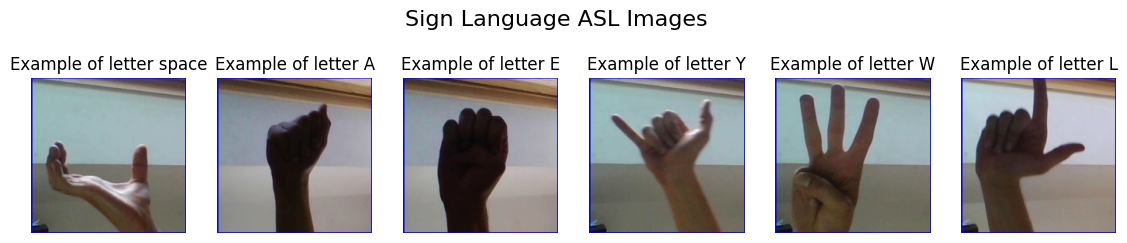

In [ ]:
# Plot one image from the first 4 letters
def plot_images(data_dir):
    fig, axes = plt.subplots(1, 6, figsize=(14, 3))
    fig.suptitle('Sign Language ASL Images', fontsize=16)
    for ii, letter in enumerate(['space','A' , 'E', 'Y', 'W', 'L']):
        letter_dir = f'{data_dir}/{letter}'
        img = tf.keras.preprocessing.image.load_img(letter_dir+'/'+letter+'10.jpg')
        axes[ii].imshow(img)
        axes[ii].set_title(f'Example of letter {letter}')
        axes[ii].axis('off')
    plt.show()
    return img
img = plot_images("/content/dataset-sign/train/")

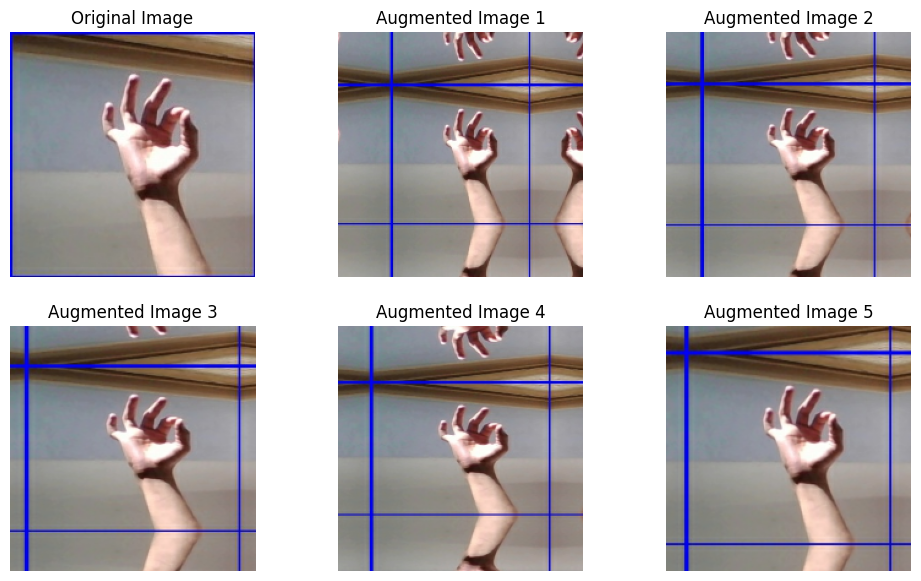

In [ ]:
# Random zoom the data
image_path = "/content/dataset-sign/train/F/F364.jpg"
hw_factor = (1, 0.0)
data_augmentation = tf.keras.Sequential([
  # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  # tf.keras.layers.RandomRotation(0.4),
  tf.keras.layers.RandomZoom(height_factor=hw_factor, width_factor=hw_factor),
])

# Load the image
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)

plt.figure(figsize=(12, 7))

# Plot original image
ax = plt.subplot(2, 3, 1)
plt.imshow(image.numpy())
plt.title("Original Image")
plt.axis("off")

# Plot augmented images
for i in range(5):
  augmented_image = data_augmentation(tf.expand_dims(image, 0))
  ax = plt.subplot(2, 3, i + 2)
  plt.imshow(tf.squeeze(augmented_image).numpy())
  plt.title(f"Augmented Image {i+1}")
  plt.axis("off")

plt.show()

done
--- 0.13034582138061523 seconds ---


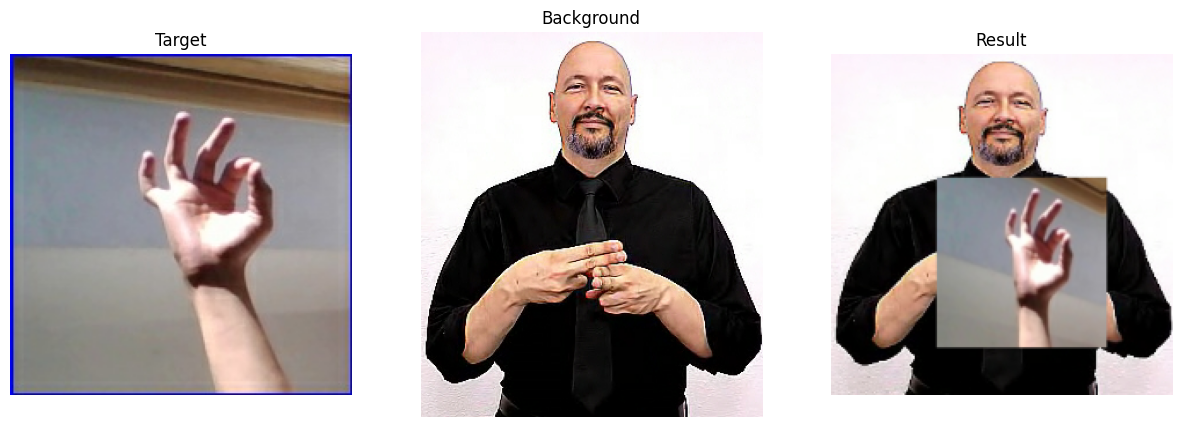

Shape of the result image: (200, 200, 3)


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


def add_image_with_transform(
    image_target_path, image_background_path, reduced_factor,
    translate_x=0, translate_y=0, rotate_factor=0.2
):
    """
    Places a target image at the center of a background image with resizing, translation, and rotation.

    Args:
        image_target_path (str): Path to the target image (foreground).
        image_background_path (str): Path to the background image.
        reduced_factor (float): Scaling factor for the target image (0 < reduced_factor <= 1).
        translate_x (int): Horizontal translation in pixels (positive for right, negative for left).
        translate_y (int): Vertical translation in pixels (positive for down, negative for up).
        rotate_angle (float): Rotation angle in degrees (clockwise).

    Returns:
        tf.Tensor: Combined image with the target image transformed and overlaid on the background.
    """
    if not (0 < reduced_factor <= 1):
        raise ValueError("reduced_factor must be between 0 and 1.")

    # Load the background and target images
    background_image = tf.image.decode_image(tf.io.read_file(image_background_path))
    target_image = tf.image.decode_image(tf.io.read_file(image_target_path))

    # Ensure images are in float32 and scaled between 0 and 1
    background_image = tf.image.convert_image_dtype(background_image, tf.float32)
    target_image = tf.image.convert_image_dtype(target_image, tf.float32)

    # Get dimensions of the background image
    bg_height, bg_width, _ = background_image.shape

    # Calculate the new dimensions for the target image
    new_height = int(bg_height * reduced_factor)
    new_width = int(bg_width * reduced_factor)

    # crop and resize the target image
    target_image = tf.image.central_crop(target_image, 0.9)

    # apply keras layers augmentation
    data_augmentation = tf.keras.Sequential([
        # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(rotate_factor),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        # tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    ])

    # augment the image
    target_image = data_augmentation(tf.expand_dims(target_image, 0))
    target_image = tf.squeeze(target_image)

    # Apply scaling
    target_image = tf.image.resize(target_image, (new_height, new_width))

    # Create a blank canvas the same size as the background
    canvas = tf.zeros_like(background_image)

    # Calculate offsets to center the target image on the canvas, with translations
    offset_height = (bg_height - new_height) // 2 + translate_y
    offset_width = (bg_width - new_width) // 2 + translate_x

    # Ensure offsets are within bounds
    offset_height = max(0, min(offset_height, bg_height - new_height))
    offset_width = max(0, min(offset_width, bg_width - new_width))

    # Overlay the resized and rotated target image onto the background
    canvas = tf.tensor_scatter_nd_update(
        canvas,
        indices=[[y + offset_height, x + offset_width, c]
                 for y in range(target_image.shape[0])
                 for x in range(target_image.shape[1])
                 for c in range(3)],
        updates=tf.reshape(target_image, [-1])
    )

    # Combine the target image with the background image
    combined_image = tf.where(canvas > 0, canvas, background_image)
    # resize the image to 200x200
    combined_image = tf.image.resize(combined_image, (200, 200))
    print("done")
    return combined_image


# Example usage
background_path = "sign_person.jpg"
target_path = "F364.jpg"
scaling_factor = 0.5
translate_x = random.randint(-30, 30)
translate_y = 25 + random.randint(0, 30)
import time
start_time = time.time()
result_image = add_image_with_transform(
    target_path, background_path, scaling_factor,
    translate_x=translate_x, translate_y=translate_y
)
print("--- %s seconds ---" % (time.time() - start_time))

# Plot the result
def plot_images(target_path, background_path, result_image):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display the target and background images
    for i, path in enumerate([target_path, background_path]):
        img = tf.image.decode_image(tf.io.read_file(path))
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title("Target" if i == 0 else "Background")

    axes[2].imshow(result_image)
    axes[2].axis("off")
    axes[2].set_title("Result")

    plt.show()

    # Print the shape of the result image
    print("Shape of the result image:", result_image.shape)

plot_images(target_path, background_path, result_image)

# full_data_augmentation = tf.keras.Sequential([


In [ ]:
# Convert the image into its numpy array representation
sample_array = tf.keras.preprocessing.image.img_to_array(img)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (200, 200, 3)


In [ ]:
sample_array[0,:5]

array([[  0.,   5., 247.],
       [  0.,   0., 244.],
       [  8.,   0., 248.],
       [  7.,   0., 248.],
       [  1.,   0., 251.]], dtype=float32)

## Creating the datasets for the CNN

In [ ]:
# def train_val_datasets():
#     """Create train and validation datasets

#     Returns:
#         (tf.data.Dataset, tf.data.Dataset): train and validation datasets
#     """
#     ### START CODE HERE ###
#     train_dataset = tf.keras.utils.image_dataset_from_directory(
#         directory=validation_data_dir,
#         batch_size=32,
#         image_size=(200,200),
# 		label_mode='categorical',
#         # Use this argument to get just one color dimension, because it is greyscale
#         color_mode = "grayscale",
#     )

#     validation_dataset = tf.keras.utils.image_dataset_from_directory(
#         directory=train_data_dir,
#         batch_size=32,
#         image_size=(200,200),
# 		label_mode='categorical',
#         # Use this argument to get just one color dimension, because it imgs are greyscale
#         color_mode = "grayscale",
#     )
#     ### END CODE HERE ###

#     return train_dataset, validation_dataset

In [ ]:
# Create train and validation datasets
# train_dataset, validation_dataset = train_val_datasets()
print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
print(f"Images of validation dataset have shape: {validation_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {validation_dataset.element_spec[1].shape}")

Found 2900 files belonging to 29 classes.
Found 1450 files belonging to 29 classes.
Images of train dataset have shape: (None, 200, 200, 1)
Labels of train dataset have shape: (None, 29)
Images of validation dataset have shape: (None, 200, 200, 1)
Labels of validation dataset have shape: (None, 29)


## Coding the CNN

In [ ]:
# display the label and the sum of it
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch.numpy().sum(axis=0))
    break

(64, 128, 128, 3)
(64, 29)
[2. 0. 1. 2. 4. 2. 1. 4. 1. 1. 4. 4. 2. 3. 3. 3. 2. 2. 3. 4. 3. 1. 2. 3.
 3. 1. 1. 1. 1.]


In [ ]:
# GRADED FUNCTION: create_model
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])
def create_model():
    """Create the classifier model

    Returns:
        tf.keras.model.Sequential: CNN for multi-class classification
    """
    ### START CODE HERE ###

    # Define the model
    # Use no more than 2 Conv2D and 2 MaxPooling2D
    model = tf.keras.models.Sequential([
        # Define an input layer
        tf.keras.Input(shape=(128,128,3)), # Set correct input size
        # Rescale images
        # data_augmentation,
        tf.keras.layers.Rescaling(1./255),

        # This is the first convolution
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        # The second convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        # The third convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(29, activation='softmax')

        ])

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    ### END CODE HERE ###
    return model

In [ ]:
# Create your model
model = create_model()

print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 128, 128, 3)
Output shape: (None, 29)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       200,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │           957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,477 (845.61 KB)

 Trainable params: 216,253 (844.74 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
with tf.device('/GPU:0'):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
  history = model.fit(train_dataset, validation_data=validation_dataset, epochs=15, callbacks=[callback])

Epoch 1/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.2963 - loss: 2.4559 - val_accuracy: 0.4121 - val_loss: 1.8582
Epoch 2/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.6434 - loss: 1.1174 - val_accuracy: 0.7147 - val_loss: 0.8709
Epoch 3/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7421 - loss: 0.7829 - val_accuracy: 0.7409 - val_loss: 0.8247
Epoch 4/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7912 - loss: 0.6237 - val_accuracy: 0.8015 - val_loss: 0.5932
Epoch 5/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8201 - loss: 0.5310 - val_accuracy: 0.6545 - val_loss: 1.2635
Epoch 6/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8414 - loss: 0.4689 - val_accuracy: 0.8493 - val_loss: 0.4471
Epoch 7/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8570 - loss: 0.4207 - val_accuracy: 0.5589 - val_loss: 1.8135
Epoch 8/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8687 -

In [ ]:
model.evaluate(validation_dataset)

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9416 - loss: 0.2222


[0.3147243559360504, 0.9048275947570801]

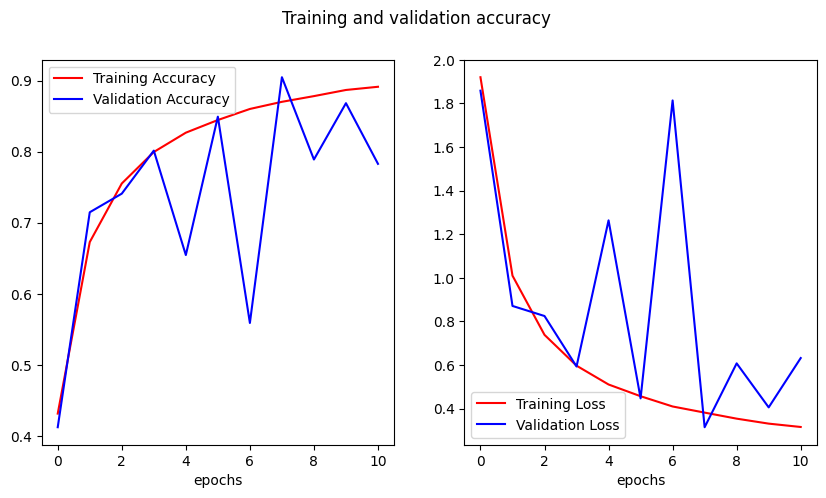

Train accuracy: 0.8914
Train loss: 0.3158
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9416 - loss: 0.2222


In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

# print the model accuracy and loss both training and validation from the last history epoch
print(f"Train accuracy: {acc[-1]:.4f}")
print(f"Train loss: {loss[-1]:.4f}")
model.evaluate(validation_dataset)

model.save('base_model.keras')

In [ ]:
# load from base_model.keras
model_base = tf.keras.models.load_model('sign_language_base_model.keras')
model_base.evaluate(validation_dataset)

136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9416 - loss: 0.2222


[0.314724326133728, 0.9048275947570801]

In [ ]:
model = tf.keras.models.load_model('sign_language_model_v1.keras')
model.evaluate(validation_dataset)

136/136 ━━━━━━━━━━━━━━━━━━━━ 151s 973ms/step - accuracy: 0.9875 - loss: 0.0499


[0.050716646015644073, 0.9871264100074768]

In [ ]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_image_class(image_path, model, class_names, show=False):
    """Predict the class of a single image

    Args:
        image_path (str): Path to the image file
        model (tf.keras.models.Model): Trained model
        class_names (list): List of class names

    Returns:
        str: Predicted class
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.resize(img_array, (128, 128))
    img_array = tf.expand_dims(img_array, 0)  # Expand dims to create batch axis

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Display the image and the predicted class
    print(f"Predicted: {predicted_class} ({image_path})")
    if show:
      plt.imshow(img)
      plt.title(f"Predicted: {predicted_class} ({image_path})")
      plt.axis('off')
      plt.show()

    return predicted_class, np.argmax(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted: W (dataset-sign/train/W/W10.jpg)


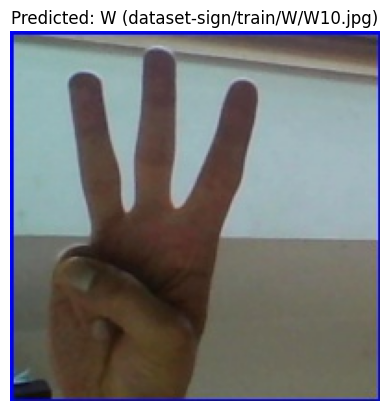

('W', 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted: W (dataset-sign/train/W/W10.jpg)
('W', 22)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted: Q (L.jpg)


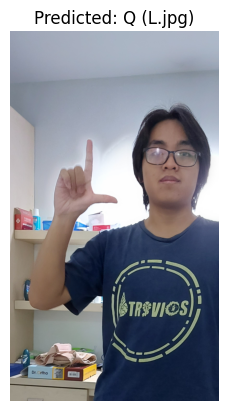

('Q', 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted: F (L.jpg)
('F', 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted: Q (W.jpg)


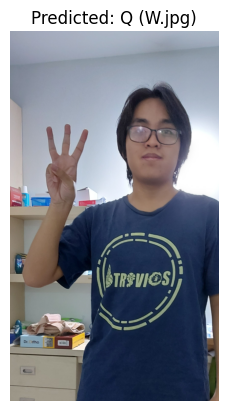

('Q', 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted: F (W.jpg)
('F', 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted: L (L2.png)


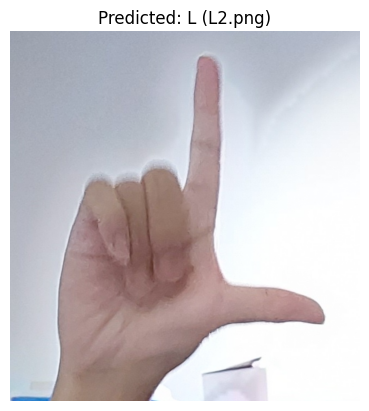

('L', 11)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted: L (L2.png)
('L', 11)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted: R (we.png)


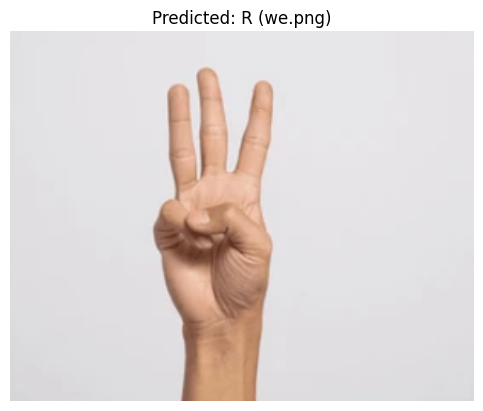

('R', 17)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted: E (we.png)
('E', 4)


In [ ]:
# Example usage:
# class_names = ['class1', 'class2', 'class3']  # Replace with actual class names
# Ensure 'model' is defined and compatible with the input shape (200, 200, 3)
path = "dataset-sign/train/W/W10.jpg"
print(predict_image_class(path, model_base, class_names, True))
print(predict_image_class(path, model, class_names))
print()
path = "L.jpg"
print(predict_image_class(path, model_base, class_names, True))
print(predict_image_class(path, model, class_names))
print()
path = "W.jpg"
print(predict_image_class(path, model_base, class_names, True))
print(predict_image_class(path, model, class_names))
print()
path = "L2.png" # ini setelah di zoom
print(predict_image_class(path, model_base, class_names, True))
print(predict_image_class(path, model, class_names))
print()
path = "we.png"
print(predict_image_class(path, model_base, class_names, True))
print(predict_image_class(path, model, class_names))

## New data

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d debashishsau/aslamerican-sign-language-aplhabet-dataset

Dataset URL: https://www.kaggle.com/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset
License(s): CC0-1.0
100% 4.18G/4.20G [00:20<00:00, 258MB/s]
100% 4.20G/4.20G [00:20<00:00, 219MB/s]


In [ ]:
! unzip "aslamerican-sign-language-aplhabet-dataset"

Streaming output truncated to the last 5000 lines.
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2863).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2864).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2865).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2866).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2867).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2868).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2869).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (287).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2870).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2871).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2872).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2873).jpg  
  inflating: A

In [ ]:
# check cuda availability
print(tf.test.is_built_with_cuda())

True


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

def load_datasets(train_dir, val_dir=None, img_width=128, img_height=128, batch_size=256):
    """
    Load datasets from the specified directories.

    Args:
        train_dir (str): Path to the training data directory.
        val_dir (str): Path to the validation data directory.
        test_dir (str): Path to the testing data directory.
        img_width (int): Width of the images to be resized to.
        img_height (int): Height of the images to be resized to.
        batch_size (int): Batch size for loading the datasets.

    Returns:
        tuple: train_dataset, validation_dataset, test_dataset
    """
    image_size = (img_width, img_height)
    buffer_size = tf.data.AUTOTUNE

    # Load training dataset
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=image_size,
        interpolation="nearest",
        batch_size=batch_size,
        shuffle=True
    )

    # Load validation dataset
    if (val_dir):
      validation_dataset = tf.keras.utils.image_dataset_from_directory(
          val_dir,
          labels='inferred',
          label_mode='categorical',
          image_size=image_size,
          interpolation="nearest",
          batch_size=batch_size,
          shuffle=False
      )
      validation_dataset = validation_dataset.cache().prefetch(buffer_size=buffer_size)
    else:
      validation_dataset = None

    # Configure datasets for performance
    train_dataset = train_dataset.cache().prefetch(buffer_size=buffer_size)

    return train_dataset, validation_dataset

In [ ]:
# asd train_asl_before, val_asl_before = load_datasets("../data/asl_alphabet_train", "../data/validation_subset")
train_asl_before, val_asl_before = load_datasets("../data/asl_alphabet_train", "C:\\Users\\user\\Downloads\\capstone\\val")
test_data, _ = load_datasets("C:\\Users\\user\\Downloads\\capstone\\test")

Found 87000 files belonging to 29 classes.
Found 8700 files belonging to 29 classes.
Found 579 files belonging to 29 classes.


In [ ]:
train_asl_dir = r'C:\Users\user\Downloads\capstone\ASL_Alphabet_Dataset\asl_alphabet_train'
train_asl, _ = load_datasets(train_asl_dir)

Found 223074 files belonging to 29 classes.


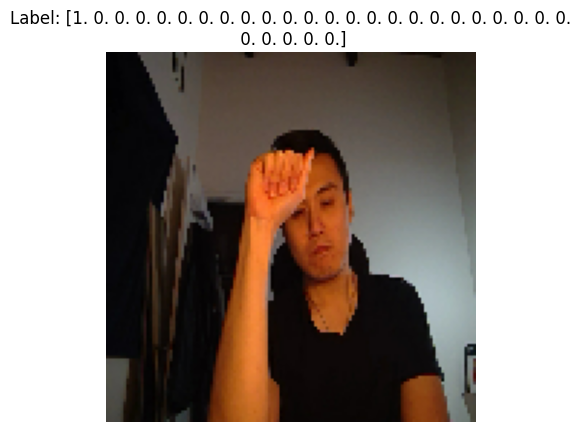

In [ ]:
import matplotlib.pyplot as plt

for image_batch, label_batch in train_asl.take(100010):
    plt.imshow(image_batch[0].numpy())
    plt.title(f"Label: {label_batch[0].numpy()}")
    plt.axis("off")
    plt.show()
    break

In [ ]:
model = tf.keras.models.load_model('sign_language_model_v2_finetune_newdata.keras')
model_v1 = tf.keras.models.load_model('sign_language_model_v1.keras')
base_model = tf.keras.models.load_model('sign_language_base_model.keras')

In [ ]:
sub_data = train_asl.take(20)
model.evaluate(sub_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.8099 - loss: 3.4429


[3.484376907348633, 0.8070312738418579]

## Saliency Maps

In [ ]:
import cv2

def do_salience(image, model, label, prefix):
  '''
  Generates the saliency map of a given image.

  Args:
    image (file) -- picture that the model will classify
    model (keras Model) -- your cats and dogs classifier
    label (int) -- ground truth label of the image
    prefix (string) -- prefix to add to the filename of the saliency map
  '''

  # Read the image and convert channel order from BGR to RGB
  # if the image is not path but image tensor type
  if isinstance(image, str):
    img = cv2.imread(image)
  else:
    img = image if isinstance(image, np.ndarray) else image.numpy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Resize the image to 128x128 and normalize pixel values to the range [0, 1]
  img = cv2.resize(img, (128,128)) / 255.0

  # Add an additional dimension (for the batch), and save this in a new variable
  img = np.expand_dims(img, axis=0)
  img_var = tf.Variable(img)

  # Declare the number of classes
  num_classes = 29

  # Define the expected output array by one-hot encoding the label
  # The length of the array is equal to the number of classes
  expected_output = tf.one_hot([label], num_classes)

  # Witin the GradientTape block:
  # Cast the image as a tf.float32
  # Use the tape to watch the float32 image
  # Get the model's prediction by passing in the float32 image
  # Compute an appropriate loss
  # between the expected output and model predictions.
  # you may want to print the predictions to see if the probabilities adds up to 1
  with tf.GradientTape() as tape:
    inputs = tf.cast(img_var, tf.float32)
    tape.watch(inputs)
    predictions = model(inputs)
    loss = tf.keras.losses.categorical_crossentropy(
        y_true=expected_output,
        y_pred=predictions,
    )

  # get the gradients of the loss with respect to the model's input image
  gradients = tape.gradient(loss, inputs)

  # generate the grayscale tensor
  grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

  # normalize the pixel values to be in the range [0, 255].
  # the max value in the grayscale tensor will be pushed to 255.
  # the min value will be pushed to 0.
  # Use the formula: 255 * (x - min) / (max - min)
  # Use tf.reduce_max, tf.reduce_min
  # Cast the tensor as a tf.uint8
  normalized_tensor = tf.cast(
      255
      * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
      / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
      tf.uint8
  )

  # Remove dimensions that are size 1
  normalized_tensor = tf.squeeze(normalized_tensor)

  # plot the normalized tensor
  # Set the figure size to 8 by 8
  # do not display the axis
  # use the 'gray' colormap
  # This code is provided for you.
  # plt.figure(figsize=(8, 8))
  # plt.axis('off')
  # plt.imshow(normalized_tensor, cmap='gray')
  # plt.show()

  # optional: superimpose the saliency map with the original image, then display it.
  # we encourage you to do this to visualize your results better
  gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
  gradient_color = gradient_color / 255.0
  # Remove the extra batch dimension from 'img' before using cv2.addWeighted
  img = img[0]  # Access the first element of the batch, which contains the image data
  super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.imshow(super_imposed)
  plt.show()

  # save the normalized tensor image to a file. this is already provided for you.
  # salient_image_name = prefix + image
  # normalized_tensor = tf.expand_dims(normalized_tensor, -1)
  # normalized_tensor = tf.io.encode_jpeg(normalized_tensor, quality=100, format='grayscale')
  # writer = tf.io.write_file(salient_image_name, normalized_tensor)

## Crop Hand

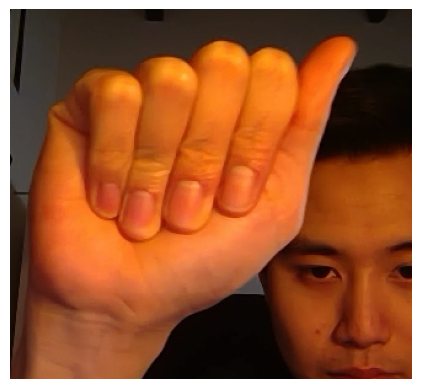

In [ ]:
# Preprocessing: Use a hand detection model (e.g., Mediapipe or YOLO) to preprocess images by cropping and focusing only on the hand region. This reduces background distractions.
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

def crop_hand(image_path):
    """Crop the hand region from an image using MediaPipe Hands.

    Args:
        image_path (str): Path to the image file.

    Returns:
        np.array: Cropped hand region.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

    # Process the image
    results = hands.process(image)

    # Get the hand landmarks
    landmarks = results.multi_hand_landmarks[0].landmark
    image_height, image_width, _ = image.shape

    # Get the bounding box
    x_min, x_max, y_min, y_max = image_width, 0, image_height, 0
    for landmark in landmarks:
        x, y = landmark.x, landmark.y
        x_pixel, y_pixel = int(x * image_width), int(y * image_height)
        x_min, x_max = min(x_min, x_pixel), max(x_max, x_pixel)
        y_min, y_max = min(y_min, y_pixel), max(y_max, y_pixel)

    # Add padding
    padding = 60
    x_min = max(0, x_min - padding)
    x_max = min(image_width, x_max + padding)
    y_min = max(0, y_min - padding)
    y_max = min(image_height, y_max + padding)

    # Crop the hand region
    hand_image = image[y_min:y_max, x_min:x_max]

    plt.imshow(hand_image)
    plt.axis("off")
    plt.show()
    return hand_image
image = "C:\\Users\\user\\Downloads\\capstone\\ASL_Alphabet_Dataset\\asl_alphabet_train\\A\\122.jpg"
hand_image = crop_hand(image)

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt


def crop_hand_(image, padding=150):
    """Crop the hand region from an image tensor using MediaPipe Hands.

    Args:
        image (np.array): Input image (numpy array or tensor of shape HWC).
        padding (int): Padding to add around the bounding box.

    Returns:
        np.array: Cropped hand region or original image if no hand detected.
    """
    # Convert tensor to numpy array (if necessary)
    if isinstance(image, tf.Tensor):
        image = image.numpy()

    # Convert the image to RGB (MediaPipe requires RGB input)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
        # Process the image
        results = hands.process(image)

        # Check if hand landmarks are detected
        if not results.multi_hand_landmarks:
            return image  # Return original image if no hands are detected

        # Get the hand landmarks and bounding box
        landmarks = results.multi_hand_landmarks[0].landmark
        image_height, image_width, _ = image.shape
        x_min, x_max, y_min, y_max = image_width, 0, image_height, 0

        for landmark in landmarks:
            x, y = landmark.x, landmark.y
            x_pixel, y_pixel = int(x * image_width), int(y * image_height)
            x_min, x_max = min(x_min, x_pixel), max(x_max, x_pixel)
            y_min, y_max = min(y_min, y_pixel), max(y_max, y_pixel)

        # Add padding and ensure coordinates are within image bounds
        x_min = max(0, x_min - padding)
        x_max = min(image_width, x_max + padding)
        y_min = max(0, y_min - padding)
        y_max = min(image_height, y_max + padding)

        # Crop the hand region
        hand_image = image[y_min:y_max, x_min:x_max]

        return hand_image

def preprocess(image, label):
    """Preprocess function to crop the hand region."""
    # Apply cropping
    image = tf.py_function(func=crop_hand_, inp=[image], Tout=tf.uint8)
    # Set the shape of the image tensor
    image.set_shape([128, 128, 3])

    return image, label


# Apply the preprocessing to the dataset
test_data_cropped = test_data.map(preprocess)

# Evaluate the model on the preprocessed test dataset
# model.evaluate(test_data_cropped)


In [ ]:
model.evaluate(test_data)

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.0727 - loss: 7.3528


[7.38428258895874, 0.06735751032829285]

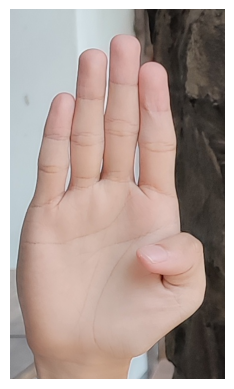

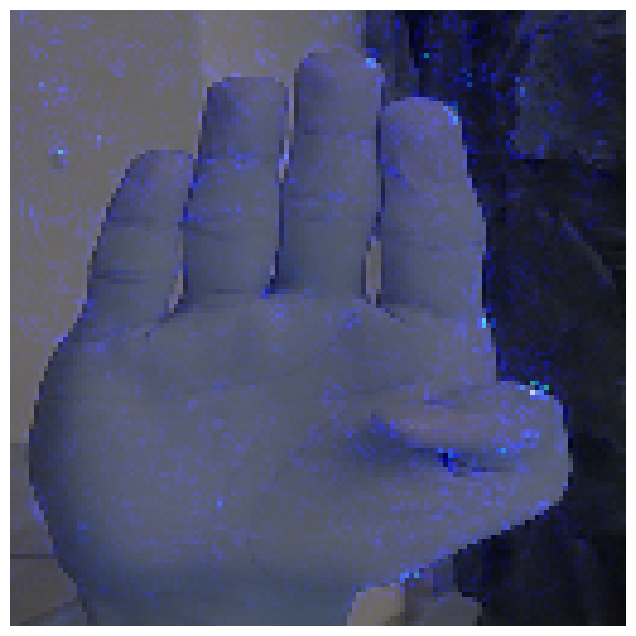

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1

In [ ]:
# Resize the hand image to match the model's expected input shape
image_path = "C:\\Users\\user\\Downloads\\capstone\\test\\A\\IMG_20241130_104251.jpg"
image_path = "C:\\Users\\user\\Downloads\\capstone\\test\\B\\IMG_20241130_104650.jpg"

# Ensure the image path is correct and the image exists
if not os.path.exists(image_path):
	raise FileNotFoundError(f"Image not found: {image_path}")

hand_image = crop_hand(image_path)
resized_hand_image = cv2.resize(hand_image, (128, 128))
resized_hand_image = np.expand_dims(resized_hand_image, axis=0)  # Add batch dimension

# Predict using the model
do_salience(hand_image, model, 0, "A")
res = model.predict(resized_hand_image)
np.argmax(res)

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

def crop_hand(image_path, padding=60):
    """Crop the hand region from an image using MediaPipe Hands."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

    results = hands.process(image)
    if not results.multi_hand_landmarks:
        return image  # Return the original image if no hands are detected

    landmarks = results.multi_hand_landmarks[0].landmark
    image_height, image_width, _ = image.shape
    x_min, x_max, y_min, y_max = image_width, 0, image_height, 0

    for landmark in landmarks:
        x, y = landmark.x, landmark.y
        x_pixel, y_pixel = int(x * image_width), int(y * image_height)
        x_min, x_max = min(x_min, x_pixel), max(x_max, x_pixel)
        y_min, y_max = min(y_min, y_pixel), max(y_max, y_pixel)

    x_min = max(0, x_min - padding)
    x_max = min(image_width, x_max + padding)
    y_min = max(0, y_min - padding)
    y_max = min(image_height, y_max + padding)

    hand_image = image[y_min:y_max, x_min:x_max]
    return hand_image

def evaluate_model_on_folder(folder_path, model, class_names):
    """Evaluate the model on a folder of images."""
    true_labels = []
    predicted_labels = []

    for label_name in class_names:
        label_folder = os.path.join(folder_path, label_name)
        if not os.path.isdir(label_folder):
            continue  # Skip if folder for the label does not exist

        for image_name in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_name)
            if not os.path.isfile(image_path):
                continue

            # Crop and resize the hand image
            hand_image = crop_hand(image_path)
            resized_hand_image = cv2.resize(hand_image, (128, 128))
            resized_hand_image = np.expand_dims(resized_hand_image, axis=0)  # Add batch dimension

            # Get the true label (index from class_names)
            true_label = class_names.index(label_name)
            true_labels.append(true_label)

            # Make prediction
            predictions = model.predict(resized_hand_image)
            predicted_label = np.argmax(predictions)
            predicted_labels.append(predicted_label)

    # Calculate accuracy, F1 score, and confusion matrix
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    cm = confusion_matrix(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels, target_names=class_names)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Example usage:
folder_path = "C:\\Users\\user\\Downloads\\capstone\\test"
evaluate_model_on_folder(folder_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model.evaluate(val_asl_before)

34/34 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9996 - loss: 0.0038


[0.0041440934874117374, 0.9993103742599487]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: A (C:\Users\user\Downloads\capstone\ASL_Alphabet_Dataset\asl_alphabet_train\A\122.jpg)


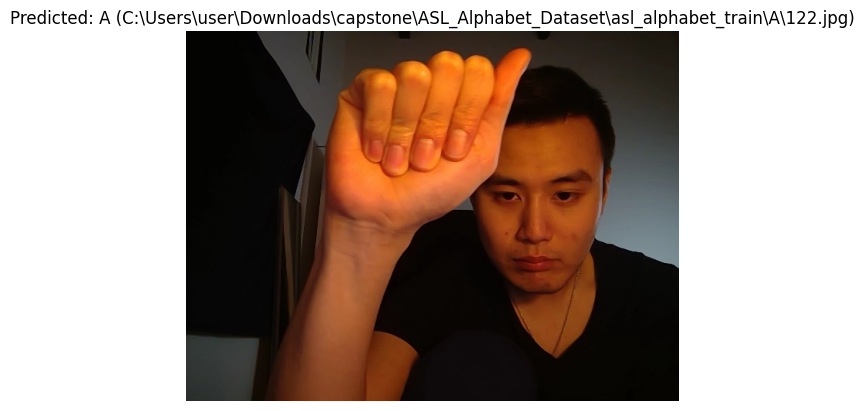

('A', 0)

In [ ]:
predict_image_class("C:\\Users\\user\\Downloads\\capstone\\ASL_Alphabet_Dataset\\asl_alphabet_train\\A\\122.jpg", model, class_names, True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted: G (C:\Users\user\Downloads\capstone\test\A\IMG_20241130_104251.jpg)


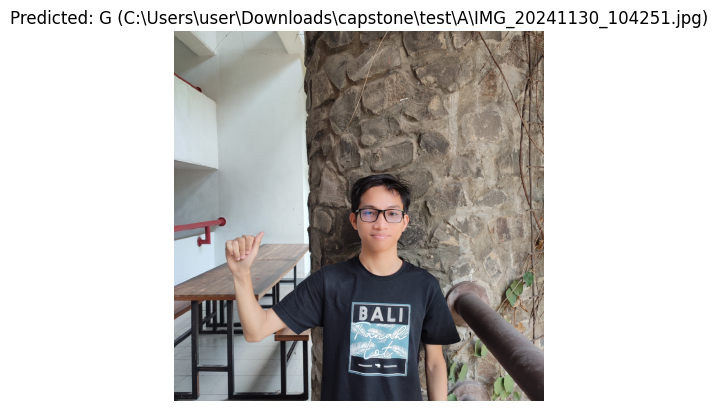

('G', 6)

In [ ]:
predict_image_class("C:\\Users\\user\\Downloads\\capstone\\test\\A\\IMG_20241130_104251.jpg", model, class_names, True)

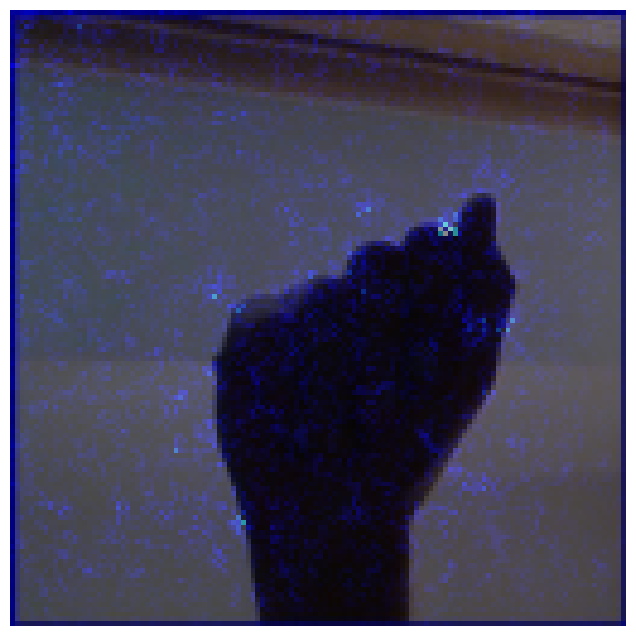

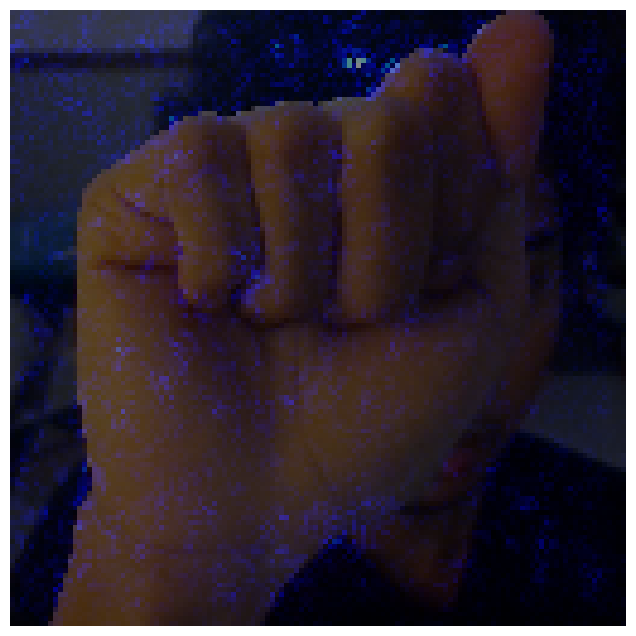

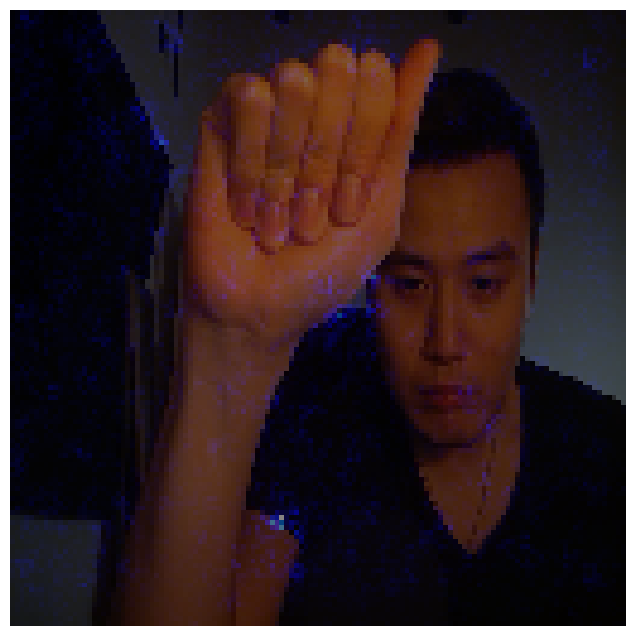

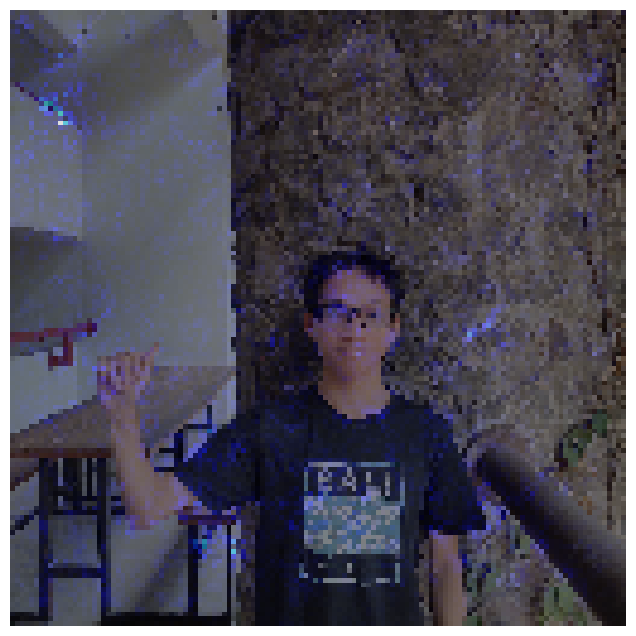

In [ ]:
img = "C:\\Users\\user\\Downloads\\capstone\\val\\A\\A85.jpg"
do_salience(img, model, 0, "A")
# do_salience(img, base_model, 0, "A")
img = "C:\\Users\\user\\Downloads\\capstone\\data\\A_test.jpg"
do_salience(img, model, 0, "A")
img = "C:\\Users\\user\\Downloads\\capstone\\ASL_Alphabet_Dataset\\asl_alphabet_train\\A\\122.jpg"
do_salience(img, model, 0, "A")
img = "C:\\Users\\user\\Downloads\\capstone\\test\\A\\IMG_20241130_104251.jpg"
do_salience(img, model, 0, "A")

In [ ]:
# img = "C:\\Users\\user\\Downloads\\capstone\\val\\A\\A85.jpg"
# do_salience(img, model, 0, "A")
# # do_salience(img, base_model, 0, "A")
# img = "C:\\Users\\user\\Downloads\\capstone\\data\\A_test.jpg"
# do_salience(img, model, 0, "A")
# img = "C:\\Users\\user\\Downloads\\capstone\\ASL_Alphabet_Dataset\\asl_alphabet_train\\A\\122.jpg"
# do_salience(img, model, 0, "A")
# img = "C:\\Users\\user\\Downloads\\capstone\\test\\A\\IMG_20241130_104251.jpg"
# do_salience(img, model, 0, "A")

In [ ]:
sub_data = train_asl.take(20)
model.evaluate(sub_data)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0 1050M    0 3050k    0     0  1171k      0  0:15:18  0:00:02  0:15:16 1172k
  1 1050M    1 14.2M    0     0  4045k      0  0:04:25  0:00:03  0:04:22 4048k
  2 1050M    2 22.1M    0     0  4914k      0  0:03:38  0:00:04  0:03:34 4917k
  2 1050M    2 28.2M    0     0  5162k      0  0:03:28  0:00:05  0:03:23 6466k
  3 1050M    3 32.8M    0     0  5085k      0  0:03:31  0:00:06  0:03:25 7512k
  3 1050M    3 36.3M    0     0  4882k      0  0:03:40  0:00:07  0:03:33 6814k
  3 1050M    3 39.6M    0     0  4721k      0  0:03:47  0:00:08  0:03:39 5209k
  4 1050M    4 44.1M    0     0  4711k      0  0:03

20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.9892 - loss: 0.0399


[0.04233377426862717, 0.9876953363418579]

## Fine Tune

In [ ]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# from tensorflow.keras.models import Model
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)  # You can adjust the number of units
# predictions = Dense(29, activation='softmax')(x) # 29 output classes

# # Create the final model
# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# # save the model
# model.save('resnet50.keras')

In [ ]:
model = tf.keras.models.load_model('resnet50.keras')
# freeze the model layers except the last stage 5th of resnet50
for layer in model.layers[:-3]:
    layer.trainable = False
    if layer.name.startswith("conv5_block3"):
        layer.trainable = True

# print all layer that trainable is True
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

# Recompile the model with a new optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
global_average_pooling2d
dense
dense_1


In [ ]:
train_asl = train_asl.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# create custom callback on batch end to clear the memory
import gc
class ClearMemory(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        tf.keras.backend.clear_session()
        gc.collect()

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(
      train_asl,
      epochs=1,
      callbacks=[ClearMemory()]
  )
model.save('resnet50_newdata.keras')


521/872 ━━━━━━━━━━━━━━━━━━━━ 27:47 5s/step - accuracy: 0.8681 - loss: 0.4753

In [ ]:
history.history

In [ ]:
import json

# # Save the history
with open('history_resnet50_newdata.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(
      train_asl,
      epochs=1,
      callbacks=[ClearMemory()]
  )
model.save('sign_language_model_v222_finetune_newdata.keras')

872/872 ━━━━━━━━━━━━━━━━━━━━ 2749s 3s/step - accuracy: 0.9400 - loss: 0.2565


In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(
      train_asl,
      epochs=1,
  )
model.save('sign_language_model_v222_finetune_newdata.keras')

872/872 ━━━━━━━━━━━━━━━━━━━━ 2299s 3s/step - accuracy: 0.9246 - loss: 0.3566


In [ ]:
model.evaluate(test_data)

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.0715 - loss: 8.1533


[8.212154388427734, 0.06390327960252762]

In [ ]:
history

{'accuracy': [0.9565704464912415], 'loss': [0.16174615919589996]}

In [ ]:
history.history

{'accuracy': [0.969176173210144], 'loss': [0.10950520634651184]}

In [ ]:
import json

# # Save the history
with open('history_ner2222222.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
model.evaluate(sub_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9853 - loss: 0.0527


[0.05372331291437149, 0.9839843511581421]

In [ ]:
# plot the history
import matplotlib.pyplot as plt

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Get training and validation accuracies
    acc = history['accuracy']

    # Get training and validation losses
    loss = history['loss']

    # Get number of epochs
    epochs = range(len(acc))

    for i, (data, label) in enumerate(zip([(acc), (loss)], ["Accuracy", "Loss"])):
        ax[i].plot(epochs, data, 'r', label="Training " + label)
        ax[i].legend()
        ax[i].set_xlabel('epochs')

    plt.show()

# Load the history
# with open('history_nerb.json', 'r') as f:
#     history = json.load(f)

plot_history(history)

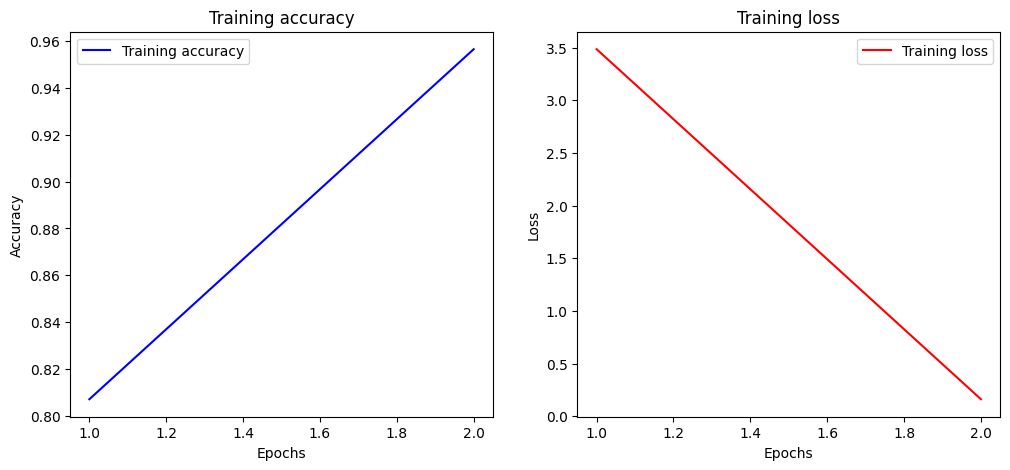

In [ ]:
# acc is from 0.8070312738418579 to 0.9565704464912415
# loss 3.484376907348633 to 0.16174615919589996

pos_hist = np.array([0.8070312738418579, 0.9565704464912415])
pos_loss = np.array([3.484376907348633, 0.16174615919589996])

history = {
    'accuracy': pos_hist,
    'loss': pos_loss
}
plot_history(history)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to simulate training history
# def simulate_training_history(epochs):
#     np.random.seed(42)  # For reproducibility
#     accuracy = np.linspace(0.5, 0.95, epochs) + np.random.normal(0, 0.001, epochs)
#     loss = np.linspace(2.0, 0.1, epochs) + np.random.normal(0, 0.005, epochs)
#     return accuracy, loss

# # Simulate training history for 50 epochs
# epochs = 50
# accuracy, loss = simulate_training_history(epochs)

# # Create a history dictionary
# history = {
#     'accuracy': accuracy,
#     'loss': loss
# }

# # Plot the simulated training history
# plot_history(history)